In [53]:
# standard imports
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import datetime as dt
import sys
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

# custom imports
sys.path.append('../src')
from fetch_range_data import fetch_range_data

# Bitcoin

The purpose of this notebook is to explore methods of bitcoin price forecasting

## Get today's data

In [2]:
# get today's data with custom function
today = dt.date.today() 
first_date = '2015/07/20'
btc = fetch_range_data('BTC/USD', first_date, today)

File exists, returned as df


In [3]:
btc.sort_index()

,date,unix,low,high,open,close,volume,vol_fiat
0,2015-11-24,1448323200,318.00,323.17,323.01,321.00,5234.702619,1.680340e+06
1,2015-11-23,1448236800,322.00,326.00,323.72,323.00,4797.364622,1.549549e+06
2,2015-11-22,1448150400,321.00,327.00,326.99,323.71,3426.178602,1.109088e+06
3,2015-11-21,1448064000,316.33,328.00,322.39,327.00,5125.958809,1.676189e+06
4,2015-11-20,1447977600,311.23,327.04,326.53,322.39,9324.440814,3.006106e+06
...,...,...,...,...,...,...,...,...
2223,2020-11-02,1604275200,13215.00,13840.00,13771.70,13563.22,12191.830710,1.653605e+08
2224,2020-11-01,1604188800,13630.05,13906.74,13803.69,13771.59,6252.006195,8.610007e+07
2225,2020-10-31,1604102400,13424.73,14098.92,13571.51,13804.81,12166.304298,1.679535e+08
2226,2020-10-30,1604016000,13131.31,13687.82,13460.00,13571.51,15664.290475,2.125881e+08


## Relabel Data

### Explore special values for BTC

In [4]:
# rename columns of btc dataframe
btc.pop('unix')
my_dict = {'date': 'Date', 'open': 'Open', 'close': 'Close', 'high': 'High', 'low': 'Low', 'volume':'Volume', 'vol_fiat':'Market Cap'}
btc.rename(columns=my_dict, inplace=True)

btc.shape

(2228, 7)

### Convert Index to Datetime

In [5]:
btc.head()

,Date,Low,High,Open,Close,Volume,Market Cap
0,2015-11-24,318.00,323.17,323.01,321.00,5234.702619,1.680340e+06
1,2015-11-23,322.00,326.00,323.72,323.00,4797.364622,1.549549e+06
2,2015-11-22,321.00,327.00,326.99,323.71,3426.178602,1.109088e+06
3,2015-11-21,316.33,328.00,322.39,327.00,5125.958809,1.676189e+06
4,2015-11-20,311.23,327.04,326.53,322.39,9324.440814,3.006106e+06


In [11]:
# # change btc index to Date column datetime objects
btc.set_index(pd.to_datetime(btc['Date']),inplace=True)

In [12]:
# sort index for ease of comparison
btc.sort_index(inplace=True)
btc

,Date,Low,High,Open,Close,Volume,Market Cap
Date,,,,,,,
2015-07-20,2015-07-20,277.37,280.00,277.98,280.00,782.883420,2.192074e+05
2015-07-21,2015-07-21,276.85,281.27,279.96,277.32,4943.559434,1.370948e+06
2015-07-22,2015-07-22,275.01,278.54,277.33,277.89,4687.909383,1.302723e+06
2015-07-23,2015-07-23,276.28,279.75,277.96,277.39,5306.919575,1.472086e+06
2015-07-24,2015-07-24,276.43,291.52,277.23,289.12,7362.469083,2.128637e+06
...,...,...,...,...,...,...,...
2021-08-20,2021-08-20,46644.95,49400.00,46769.02,49342.40,13184.670486,6.505633e+08
2021-08-21,2021-08-21,48285.28,49821.92,49349.99,48867.02,9574.836152,4.678937e+08
2021-08-22,2021-08-22,48102.89,49526.13,48870.21,49284.63,6243.396434,3.077035e+08


In [14]:
btc

,Low,High,Open,Close,Volume,Market Cap
Date,,,,,,
2015-07-20,277.37,280.00,277.98,280.00,782.883420,2.192074e+05
2015-07-21,276.85,281.27,279.96,277.32,4943.559434,1.370948e+06
2015-07-22,275.01,278.54,277.33,277.89,4687.909383,1.302723e+06
2015-07-23,276.28,279.75,277.96,277.39,5306.919575,1.472086e+06
2015-07-24,276.43,291.52,277.23,289.12,7362.469083,2.128637e+06
...,...,...,...,...,...,...
2021-08-20,46644.95,49400.00,46769.02,49342.40,13184.670486,6.505633e+08
2021-08-21,48285.28,49821.92,49349.99,48867.02,9574.836152,4.678937e+08
2021-08-22,48102.89,49526.13,48870.21,49284.63,6243.396434,3.077035e+08


In [8]:
type(btc.index)

pandas.core.indexes.range.RangeIndex

In [9]:
btc.columns

Index(['Date', 'Low', 'High', 'Open', 'Close', 'Volume', 'Market Cap'], dtype='object')

### Resampling

In [10]:
btcM = btc.resample('M').mean()
btcM

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'RangeIndex'

In [ ]:
btcD = btcM.resample('D').mean()
btcD

# Visualizations

In [15]:
# create xticklabels
xticks_min = []
xticks_maj = []
xlabels_min = []
xlabels_maj = []
year = 0
month = 0

for index in btc.index:
    if year != index.year:
        year = index.year
        xticks_maj.append(index)
        xlabels_maj.append(year)
    if month != index.month:
        month = index.month
        xticks_min.append(index)
        xlabels_min.append(month)


Text(0.5, 1.0, 'Bitcoin Price over Time')

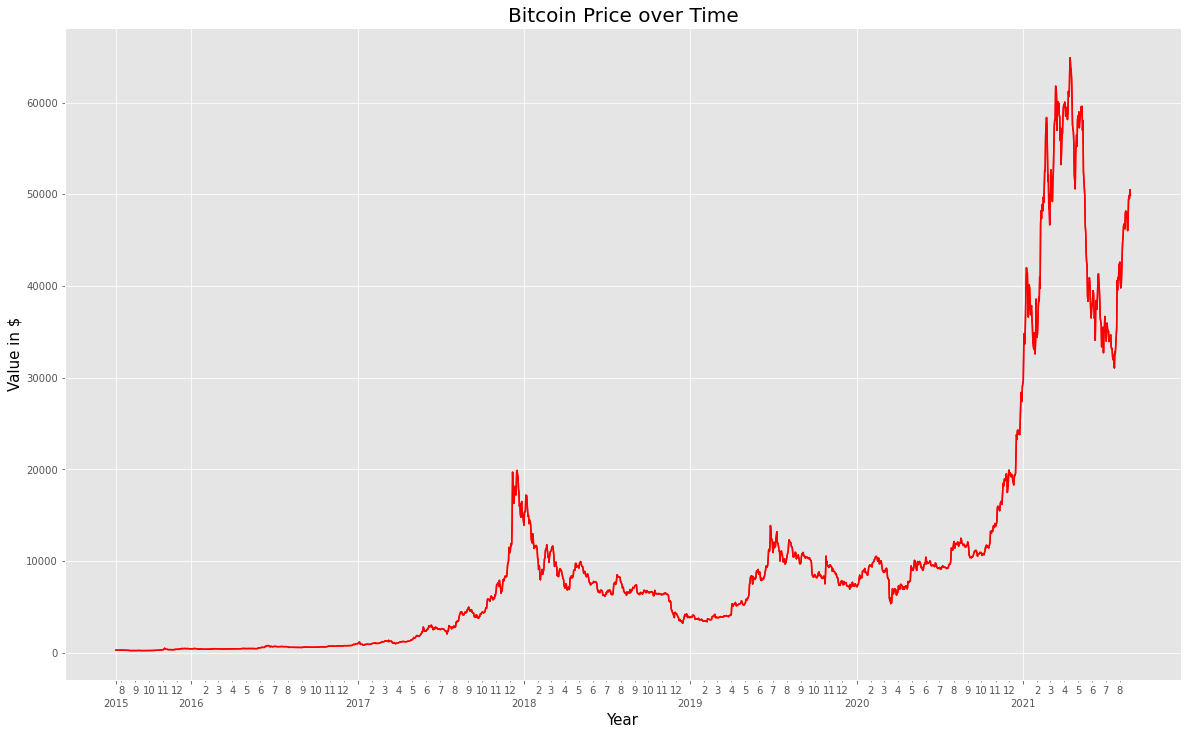

In [16]:
# plot daily high values of data
plt.style.use('ggplot')
figsize = (20,12)
fig, ax = plt.subplots(figsize=figsize)
ax.plot(btc.index, btc.High, c='r', lw=1.5)
ax.plot(btc.index, btc.High, c='r', lw=1.5)

ax.set_xticks(xticks_min, minor=True)
ax.set_xticklabels(xlabels_min, minor=True)
ax.set_xticks(xticks_maj, minor=False)
ax.set_xticklabels(xlabels_maj, minor=False)

ax.tick_params(axis='x', which='major', direction='out', rotation=0, pad=15)
ax.tick_params(axis='x', which='minor', direction='out', rotation=0)

ax.set_xlabel("Year", fontsize=15, color='black')
ax.set_ylabel('Value in $', fontsize=15, color='black')
ax.set_title('Bitcoin Price over Time', fontsize=20, color='black')
# plt.savefig('bitcoin_historical_transparent.png', transparent=True, dpi=400)
# plt.savefig('bitcoin_historical.png', transparent=False, dpi=400)

Text(0.5, 1.0, 'Bitcoin Daily Closing Price')

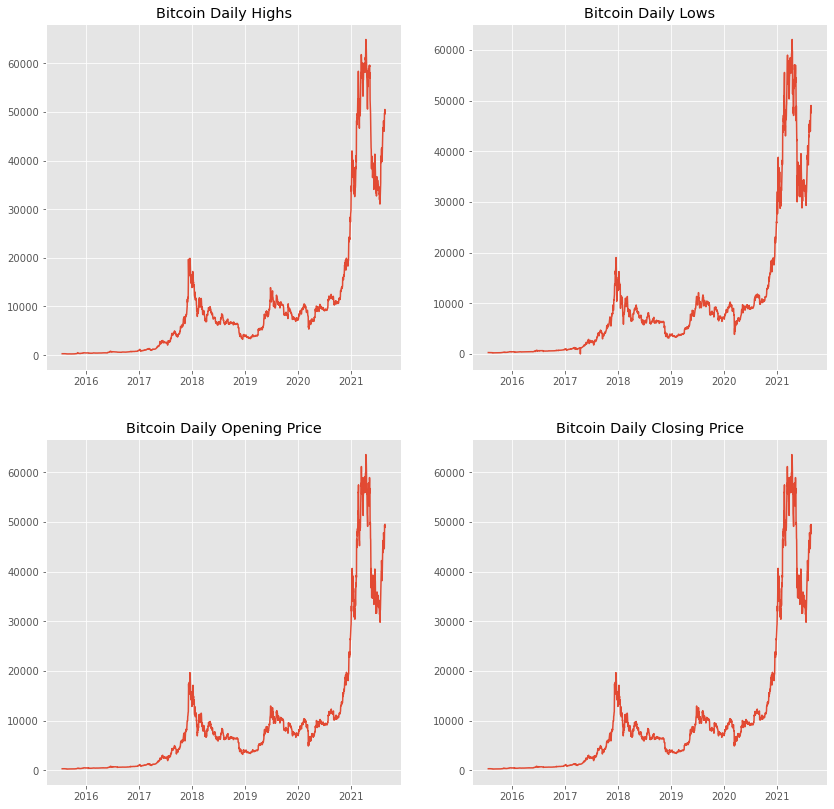

In [17]:
m = 2
n = 2
figsize = (14,14)
fig, ax = plt.subplots(nrows=m, ncols=n, figsize=figsize)

ax[0,0].plot(btc.index, btc.High)
ax[0,1].plot(btc.index, btc.Low)
ax[1,0].plot(btc.index, btc.Open)
ax[1,1].plot(btc.index, btc.Close)

ax[0,0].set_title('Bitcoin Daily Highs')
ax[0,1].set_title('Bitcoin Daily Lows')
ax[1,0].set_title('Bitcoin Daily Opening Price')
ax[1,1].set_title('Bitcoin Daily Closing Price')

Text(0.5, 1.0, 'Bitcoin Daily Closing')

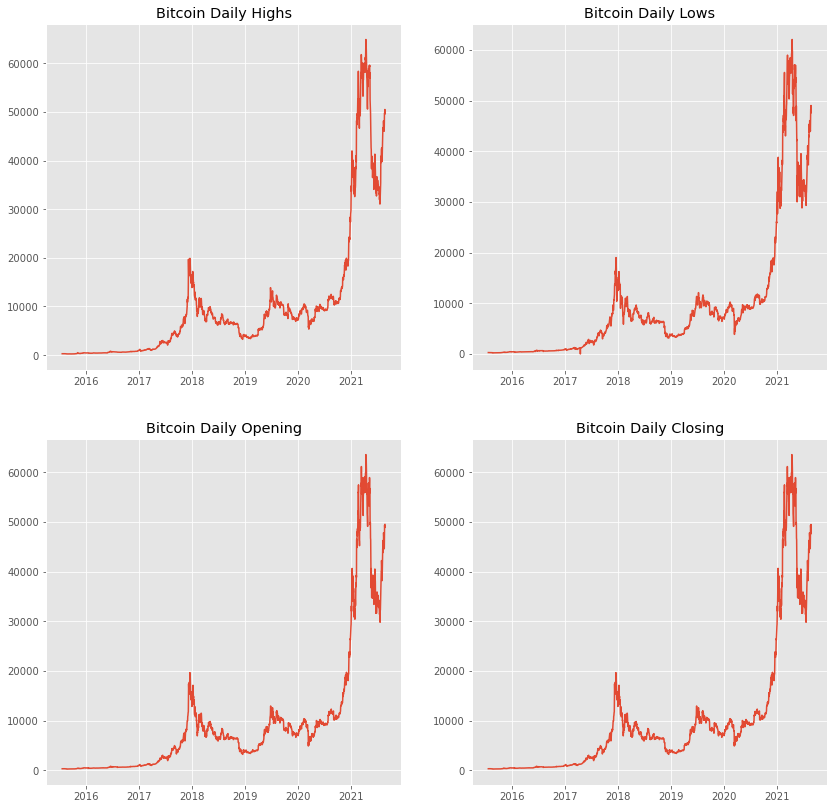

In [18]:
m = 2
n = 2
figsize = (14,14)
fig, ax = plt.subplots(nrows=m, ncols=n, figsize=figsize)

ax[0,0].plot(btc.index, btc.High)
ax[0,1].plot(btc.index, btc.Low)
ax[1,0].plot(btc.index, btc.Open)
ax[1,1].plot(btc.index, btc.Close)

ax[0,0].set_title('Bitcoin Daily Highs')
ax[0,1].set_title('Bitcoin Daily Lows')
ax[1,0].set_title('Bitcoin Daily Opening')
ax[1,1].set_title('Bitcoin Daily Closing')

# First Simple Model - Random Walk

In [19]:
end_of_train_index = int(btc.shape[0]*0.8)
end_of_train_index

1782

In [20]:
# separate train and test data
# roughly first 80% of data
train = btc.Close[:end_of_train_index]

# roughly last 20% of data
test = btc.Close[end_of_train_index:]

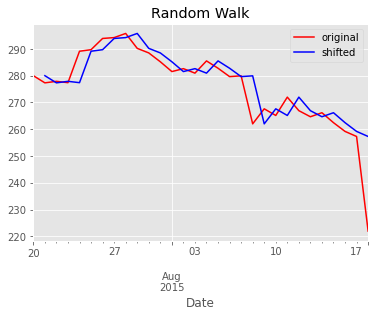

In [21]:
# create "random walk" model, shift values by 1 day
random_walk = train.shift(1)

# create plot of first 30 values of train and random walk
fig, ax = plt.subplots()

train[0:30].plot(ax=ax, c='r', label='original')
random_walk[0:30].plot(ax=ax, c='b', label='shifted')
ax.set_title('Random Walk')
ax.legend();

In [22]:
random_walk.dropna(inplace=True)

In [23]:
import sklearn.metrics as metric

In [24]:
train.shape[0]

1782

In [25]:
random_walk[:3]

Date
2015-07-21    280.00
2015-07-22    277.32
2015-07-23    277.89
Name: Close, dtype: float64

In [26]:
train[:3]

Date
2015-07-20    280.00
2015-07-21    277.32
2015-07-22    277.89
Name: Close, dtype: float64

In [27]:
train.index

DatetimeIndex(['2015-07-20', '2015-07-21', '2015-07-22', '2015-07-23',
               '2015-07-24', '2015-07-25', '2015-07-26', '2015-07-27',
               '2015-07-28', '2015-07-29',
               ...
               '2020-05-26', '2020-05-27', '2020-05-28', '2020-05-29',
               '2020-05-30', '2020-05-31', '2020-06-01', '2020-06-02',
               '2020-06-03', '2020-06-04'],
              dtype='datetime64[ns]', name='Date', length=1782, freq=None)

In [28]:
random_walk.index

DatetimeIndex(['2015-07-21', '2015-07-22', '2015-07-23', '2015-07-24',
               '2015-07-25', '2015-07-26', '2015-07-27', '2015-07-28',
               '2015-07-29', '2015-07-30',
               ...
               '2020-05-26', '2020-05-27', '2020-05-28', '2020-05-29',
               '2020-05-30', '2020-05-31', '2020-06-01', '2020-06-02',
               '2020-06-03', '2020-06-04'],
              dtype='datetime64[ns]', name='Date', length=1781, freq=None)

In [29]:
metric.mean_squared_error(train[1:], random_walk)

94735.59835457605

In [30]:
metric.mean_squared_log_error(train['2015-07-21':'2015-08-30'], random_walk['2015-07-21':'2015-08-30'])

0.001077400777264864

## ARIMA MODEL

In [34]:
from statsmodels.tsa.arima.model import ARIMA

from sklearn.model_selection import TimeSeriesSplit

In [35]:
# create timeseriessplit object
data = btc.Close
n = 5
tss = TimeSeriesSplit(n_splits = n)
split_data = tss.split(data)

In [36]:
# save split data for time series cross val
i = 0
tss_train = []
tss_test = []
for j, k in split_data:
    # use globals to save 
    tss_train.append(j)
    tss_test.append(k)
    
tss_train = np.array(tss_train)
tss_test = np.array(tss_test)

<ipython-input-36-a5b0db9321a8>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  tss_train = np.array(tss_train)


In [37]:
# define function to print min and max of array/list
def print_info(input_):
    min_value = min(input_) 
    max_value = max(input_)
    
    return f'min: {min_value} max: {max_value}\n'

In [38]:
# iterate through timeseriessplit object and print info
for train_index, test_index in tss.split(data):
    print('Train:', print_info(train_index))
    print('Test:', print_info(test_index))

Train: min: 0 max: 372

Test: min: 373 max: 743

Train: min: 0 max: 743

Test: min: 744 max: 1114

Train: min: 0 max: 1114

Test: min: 1115 max: 1485

Train: min: 0 max: 1485

Test: min: 1486 max: 1856

Train: min: 0 max: 1856

Test: min: 1857 max: 2227



In [39]:
for i in tss_train:
    print(max(i))

372
743
1114
1485
1856


In [40]:
for i in tss_test:
    print(max(i))

743
1114
1485
1856
2227


In [41]:
test_index[1]

1858

### Random Walk with ARIMA

In [42]:
x = btc['Close'].iloc[train_index[0]]
x
# x.append(btc['Close'].iloc[train_index[1]])
# x

280.0

In [43]:
# create endog and exog variables for fitting
endog = train
endog.index = train.index.to_period('D')

In [44]:
# CREATE arima_model object, pass training set and order

# (0,1,0) as the order means 1st order differenced model, essentially a random walk

rw = ARIMA(endog, order=(0,1,0)).fit()

y_hat = rw.predict(typ='levels')
y_hat

Date
2015-07-20        0.00
2015-07-21      280.00
2015-07-22      277.32
2015-07-23      277.89
2015-07-24      277.39
                ...   
2020-05-31     9700.33
2020-06-01     9446.57
2020-06-02    10208.96
2020-06-03     9522.46
2020-06-04     9668.07
Freq: D, Length: 1782, dtype: float64

In [45]:
# find squared error and compare to random walk model generated manually
metric.mean_squared_error(train[:], y_hat)

94726.43135213242

### 1st Order ARIMA

In [46]:
# # create endog and exog variables for fitting
# endog = train
# endog.index = endog.index.to_period('D')

In [47]:
btc.columns

Index(['Low', 'High', 'Open', 'Close', 'Volume', 'Market Cap'], dtype='object')

In [48]:
btc

,Low,High,Open,Close,Volume,Market Cap
Date,,,,,,
2015-07-20,277.37,280.00,277.98,280.00,782.883420,2.192074e+05
2015-07-21,276.85,281.27,279.96,277.32,4943.559434,1.370948e+06
2015-07-22,275.01,278.54,277.33,277.89,4687.909383,1.302723e+06
2015-07-23,276.28,279.75,277.96,277.39,5306.919575,1.472086e+06
2015-07-24,276.43,291.52,277.23,289.12,7362.469083,2.128637e+06
...,...,...,...,...,...,...
2021-08-20,46644.95,49400.00,46769.02,49342.40,13184.670486,6.505633e+08
2021-08-21,48285.28,49821.92,49349.99,48867.02,9574.836152,4.678937e+08
2021-08-22,48102.89,49526.13,48870.21,49284.63,6243.396434,3.077035e+08


In [49]:
endog

Date
2015-07-20      280.00
2015-07-21      277.32
2015-07-22      277.89
2015-07-23      277.39
2015-07-24      289.12
                ...   
2020-05-31     9446.57
2020-06-01    10208.96
2020-06-02     9522.46
2020-06-03     9668.07
2020-06-04     9788.03
Freq: D, Name: Close, Length: 1782, dtype: float64

In [50]:
# CREATE arima_model object, pass training set and order

# (1,1,0) as the order means 1st order differenced model, with additional lag

ar_1 = ARIMA(train, order=(1,1,0)).fit()

y_hat = ar_1.predict()
y_hat 

Date
2015-07-20        0.000000
2015-07-21      279.948739
2015-07-22      277.325667
2015-07-23      277.888795
2015-07-24      277.391057
                  ...     
2020-05-31     9699.745365
2020-06-01     9447.106573
2020-06-02    10207.347935
2020-06-03     9523.911596
2020-06-04     9667.762109
Freq: D, Length: 1782, dtype: float64

In [32]:
test[]

SyntaxError: invalid syntax (<ipython-input-32-cb83647af7c0>, line 1)

In [33]:
y_hat = ar_1.predict(start=test.index[0], end=test.index[-1])

NameError: name 'ar_1' is not defined

In [69]:
btc.loc['2020-06-05']

Low           9.585440e+03
High          9.855000e+03
Open          9.791960e+03
Close         9.613210e+03
Volume        1.249590e+04
Market Cap    1.201257e+08
Name: 2020-06-05 00:00:00, dtype: float64

In [62]:
y_hat

2020-06-05    9787.776346
2020-06-06    9787.776882
2020-06-07    9787.776881
2020-06-08    9787.776881
2020-06-09    9787.776881
                 ...     
2021-08-20    9787.776881
2021-08-21    9787.776881
2021-08-22    9787.776881
2021-08-23    9787.776881
2021-08-24    9787.776881
Freq: D, Length: 446, dtype: float64

In [ ]:
metric.mean_squared_error(train, y_hat)

In [72]:
train

date
2015-07-20      280.00
2015-07-21      277.32
2015-07-22      277.89
2015-07-23      277.39
2015-07-24      289.12
                ...   
2020-05-31     9446.57
2020-06-01    10208.96
2020-06-02     9522.46
2020-06-03     9668.07
2020-06-04     9788.03
Freq: D, Name: Close, Length: 1782, dtype: float64

In [78]:
# CREATE arima_model object, pass training set and order

# try higher order models

ar_2 = ARIMA(train, (1,2,1)).fit()

# y_hat = ar_2.predict(typ='levels')
# y_hat

ValueError: endog and exog matrices are different sizes

In [ ]:
metric.mean_squared_error(train[2:], y_hat)

In [ ]:
ar_2.summary()

In [ ]:
# additoinal ARIMIA model
ar_3 = ARIMA(train, (4,2,3), freq='D').fit()

y_hat = ar_3.predict(typ='levels')
y_hat

In [ ]:
metric.mean_squared_error(train[2:], y_hat)

In [ ]:
# additoinal ARIMIA model
ar_4 = ARIMA(train, (1,1,4), freq='D').fit()

y_hat = ar_4.predict(typ='levels')
metric.mean_squared_error(train[1:], y_hat)

In [ ]:
TimeSeriesSplit(5, btc['Close'], max_train_size=0.8*btc.shape[0])

### Make function to make data reshaping easier

In [ ]:
# function converts data to array and reshapes for linreg compatibility 
def arr_shape(data):
    data = np.array(data)
    data = data.reshape(-1,1)
    return data

## auto_arima

In [67]:
arima_model = auto_arima(train,
                         start_p=0,d=0,start_q=0,
                         max_p=4,max_d=4,max_q=4,
                         start_P=0,D=1,start_Q=0,
                         max_P=1,max_D=1,max_Q=1,m=96,
                         seasonal=True,
                         error_action='warn',trace=True,
                         supress_warning=True,stepwise=True,
                         random_state=20,n_fits=1)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[96] intercept   : AIC=31787.622, Time=7.19 sec
 ARIMA(1,0,0)(1,1,0)[96] intercept   : AIC=inf, Time=253.41 sec
 ARIMA(0,0,1)(0,1,1)[96] intercept   : AIC=inf, Time=531.80 sec
 ARIMA(0,0,0)(0,1,0)[96]             : AIC=31820.536, Time=8.42 sec


MemoryError: Unable to allocate 501. MiB for an array with shape (192, 192, 1783) and data type float64

In [ ]:
(0,0,0)(0,1,0)[96]

In [ ]:
non_auto_arima = SARIMAX(train,
                        order=(1,1,0),
                        seasonal_order=(1,1,1,96),
                        freq='D').fit()

In [56]:
non_auto_arima = SARIMAX(train,
                        order=(0,0,0),
                        seasonal_order=(0,1,0,96),
                        freq='D').fit()

In [64]:
y_pred = non_auto_arima.predict(start='2020-06-05')

In [65]:
y_pred

2020-06-05    8522.31
Freq: D, dtype: float64

In [61]:
train

Date
2015-07-20      280.00
2015-07-21      277.32
2015-07-22      277.89
2015-07-23      277.39
2015-07-24      289.12
                ...   
2020-05-31     9446.57
2020-06-01    10208.96
2020-06-02     9522.46
2020-06-03     9668.07
2020-06-04     9788.03
Freq: D, Name: Close, Length: 1782, dtype: float64

In [66]:
test[0]

9613.21

## Linear Regression

In [55]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [70]:
btc.shape

(2201, 6)

In [68]:
btc.Close

Date
2015-07-20      280.00
2015-07-21      277.32
2015-07-22      277.89
2015-07-23      277.39
2015-07-24      289.12
                ...   
2021-07-24    34283.01
2021-07-25    35428.26
2021-07-26    37262.77
2021-07-27    39470.48
2021-07-28    40035.10
Name: Close, Length: 2201, dtype: float64

In [139]:
close = btc.Close
close.reset_index(drop=True, inplace=True)
close_index = close.index
close = np.squeeze(close.to_numpy())
close_index = np.squeeze(close_index.to_numpy())

In [153]:
close_index[0]

0

In [155]:
# # separate data for linear regression
X_train, X_test, y_train, y_test = train_test_split(close_index, close)

# reshape for linreg
X_train = arr_shape(X_train)
X_test = arr_shape(X_test)
y_train = arr_shape(y_train)
y_test = arr_shape(y_test)


In [156]:
y_train

array([[ 2786.07],
       [ 4214.84],
       [  238.34],
       ...,
       [ 6928.5 ],
       [ 1292.86],
       [50089.15]])

In [157]:
X_train

array([[ 739],
       [ 807],
       [  73],
       ...,
       [ 985],
       [ 592],
       [2105]], dtype=int64)

In [158]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [159]:
preds = lr.predict(X_test)

In [160]:
lr.intercept_

array([-5766.96796992])

In [163]:
lr.coef_

array([[13.56697558]])